In [2]:
import torch
from torchvision.models import vgg11_bn, VGG11_BN_Weights

import numpy as np
import collections

c:\users\qxx2924\documents\projekte\phd\kernels_entropy\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
models_weights = VGG11_BN_Weights.DEFAULT
model = vgg11_bn(weights=models_weights)
model.eval()
print(model)

weights, weights_names, all_layers  = return_weights(model, "vgg11")
print(weights_names)
print(all_layers)
preprocess = models_weights.transforms()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

0.9999516394153064
0.9998029672809625
0.9999596583995213
0.9996047135997016
0.9995997723685836
0.9993707714876481
0.9998876006623845
0.9999924737396195
0.9999349586942423


c:\users\qxx2924\documents\projekte\phd\kernels_entropy\venv\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


batch shape: torch.Size([10000, 3, 32, 32])


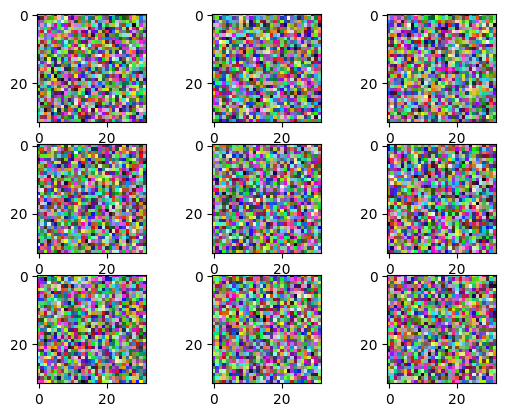

In [12]:
import matplotlib.pyplot as plt

# mean and std of imagenet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
row = 32
col = 32

fig, axs = plt.subplots(3,3)
for x in range(3):
    for y in range(3):
        uniform_noise = np.random.uniform(low=0.0, high=1.0, size=(row, col, 3))
        axs[x][y].imshow(uniform_noise) 
        print(np.max(uniform_noise))
fig.show()

# The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# batch = preprocess(gaussian).unsqueeze(0)
batch_size = 100 # not needed - since it so far fits in RAM
dataset_len = 10000
dataset = list()

for index in range(dataset_len):
    uniform_noise =np.random.uniform(low=0.0, high=1.0, size=(3, row, col))
    dataset.append(uniform_noise)
    
dataset_numpy = np.asarray(dataset)
#print(dataset_numpy.shape)
np.save('batch_{}_dataset_len_{}'.format(batch_size, dataset_len), dataset_numpy, allow_pickle =False)

batch = torch.Tensor(dataset_numpy)
print("batch shape: {}".format(batch.shape))

In [13]:
def plot_feature_maps(outputs, names):
    img_in_row = 8
    for x, (feature_map, name) in enumerate(zip(outputs, names)):
        #print(feature_map.shape)
        if isinstance(feature_map, torch.Tensor):
            images =(feature_map.squeeze(0).detach().numpy())[:3,:,:]
        else:
            images = feature_map[:img_in_row,:,:]
        images = np.moveaxis(images, 0, -1)
        #print(images.shape)
        fig, axs = plt.subplots(nrows=1, ncols=img_in_row, figsize=(18,18))
        axs[3].set_title("{}: layer: {}".format(x, name))
        #fig.suptitle("Layer:")
        for y in range(img_in_row):
            axs[y].imshow(images[0, :, :, y])
        plt.tight_layout()
        fig.savefig("{}_feature_map.png".format(name), dpi=300)

In [27]:
def plot_feature_maps_entropy(layers_entropy, name):
    #plt.bar(np.arange(len(layers_entropy)), layers_entropy)
    plt.plot(layers_entropy, "*")
    plt.tight_layout()
    plt.savefig("{}_entropy.png".format(name), dpi=300)
    plt.show()

In [28]:
import torch.nn as nn
from scipy.stats import entropy
from tqdm import tqdm

batch_norm_weights = list()
conv_layers = list()
batch_norm_layers = list()

# get all the model children as list
model_children = list(model.children())
#print(model_children)

for i in range(len(model_children)):
    
    if isinstance(model_children[i], torch.nn.modules.conv.Conv2d):
        #model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
        
    elif isinstance(model_children[i], torch.nn.modules.container.Sequential):
        #print(len(model_children[i]))
        for j in range(len(model_children[i])):
            child = model_children[i][j]
            #print(type(child))
            if isinstance(child, torch.nn.modules.conv.Conv2d):
                #model_weights.append(child.weight)
                conv_layers.append(child)
            elif isinstance(child, torch.nn.modules.batchnorm.BatchNorm2d):
                batch_norm_weights.append((child.weight.detach().numpy(), child.bias.detach().numpy()))
                batch_norm_layers.append(child)

True
(64, 8, 32, 32)
Layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 5.4417153889572285


c:\users\qxx2924\documents\projekte\phd\kernels_entropy\venv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


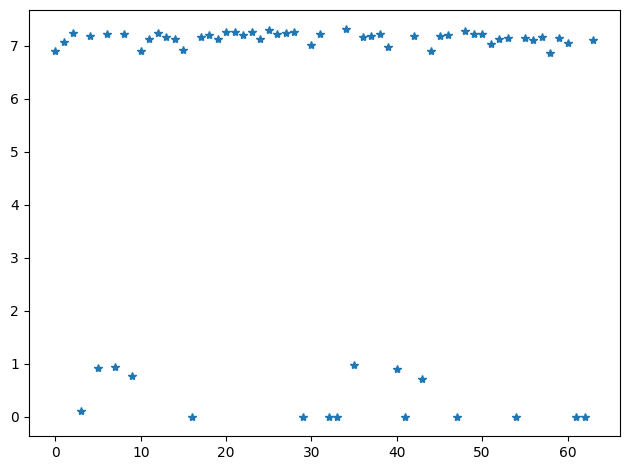

(128, 8, 32, 32)
Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 6.87788718727934


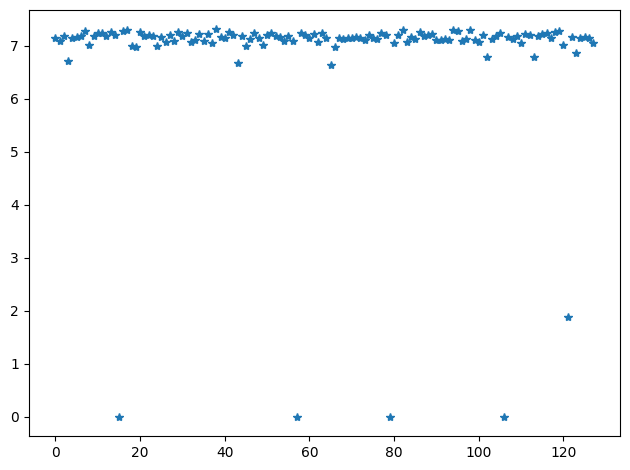

(256, 8, 32, 32)
Layer: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 6.978923085820313


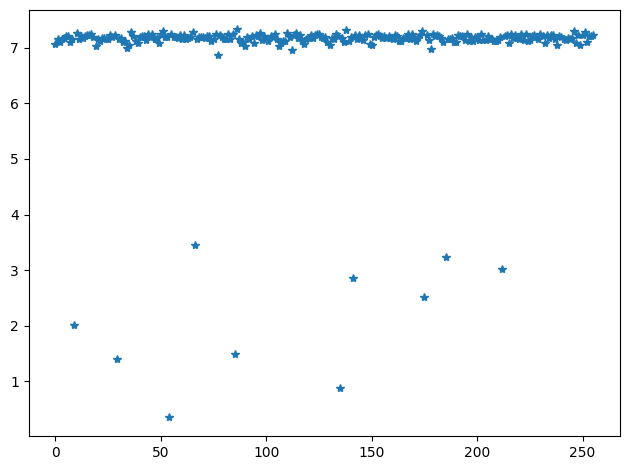

(256, 8, 32, 32)
Layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 7.194482377932694


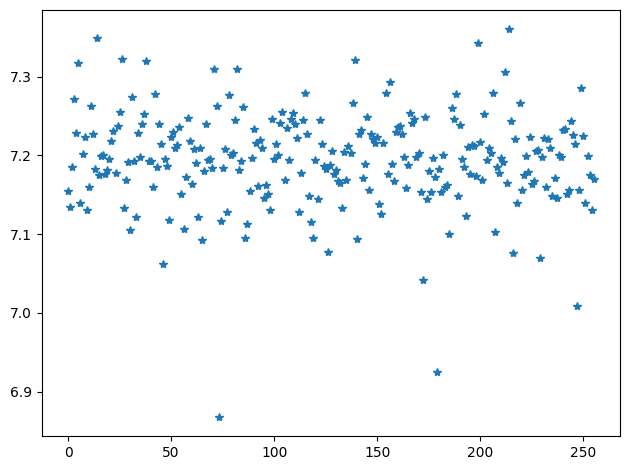

(512, 8, 32, 32)
Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 7.200100862101463


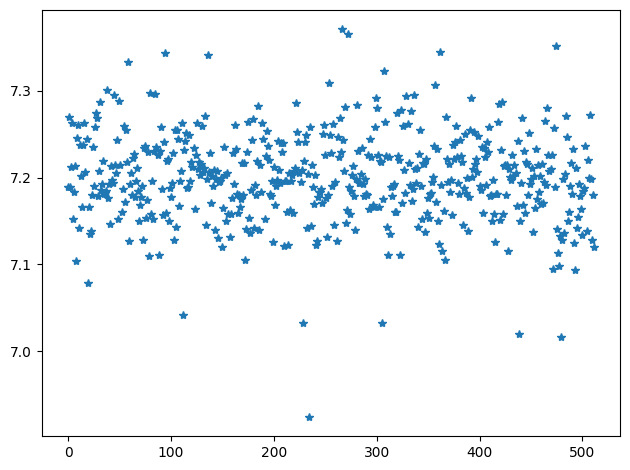

(512, 8, 32, 32)
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 7.215944072742524


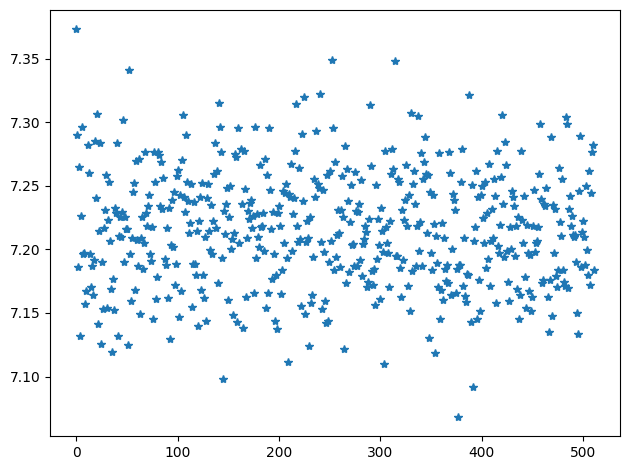

(512, 8, 32, 32)
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 7.2243006978722


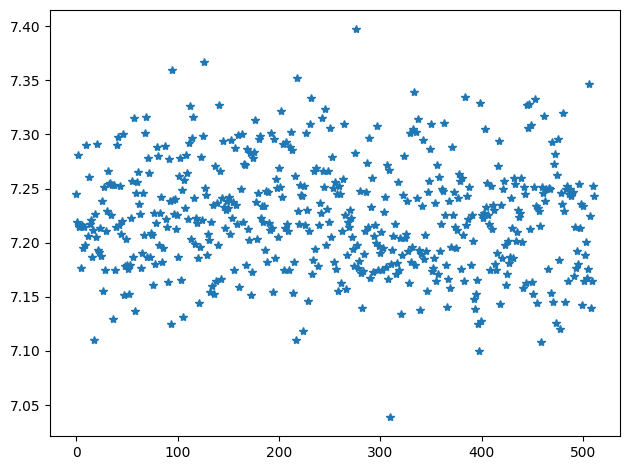

(512, 8, 32, 32)
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Shannon entropy in bits: 7.231326554659721


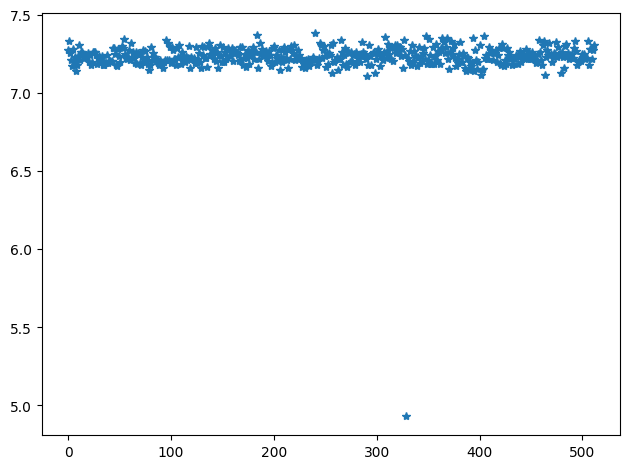

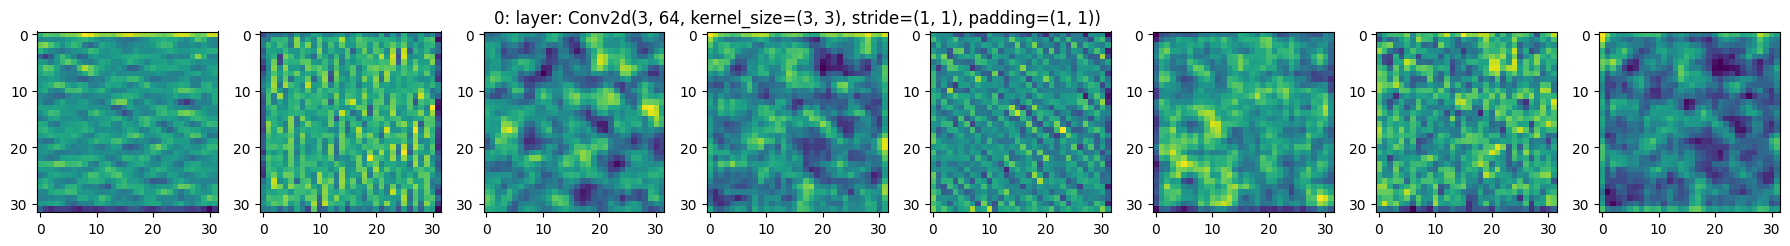

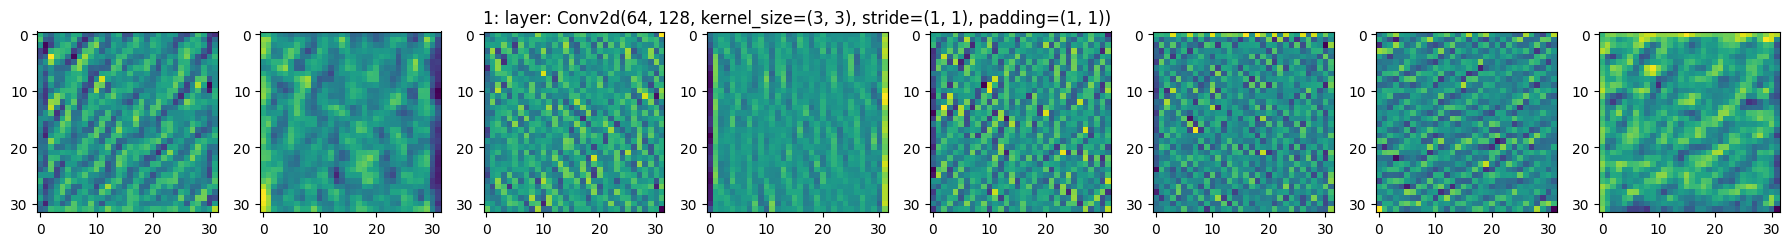

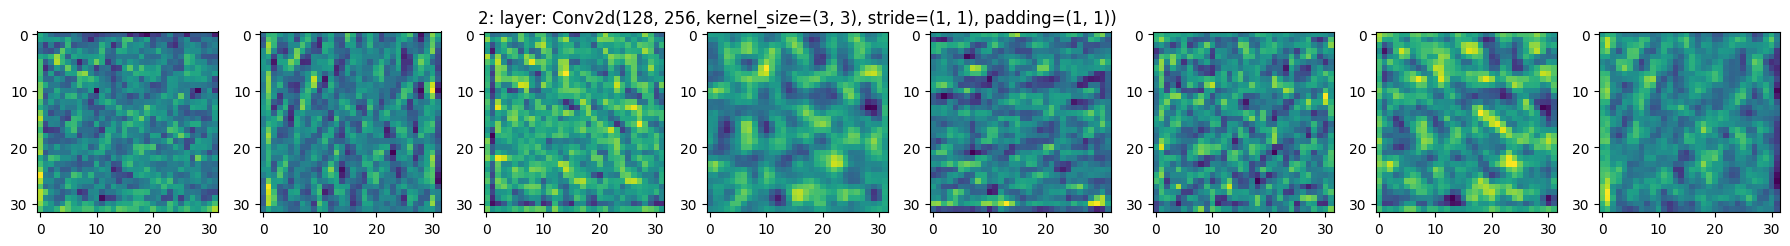

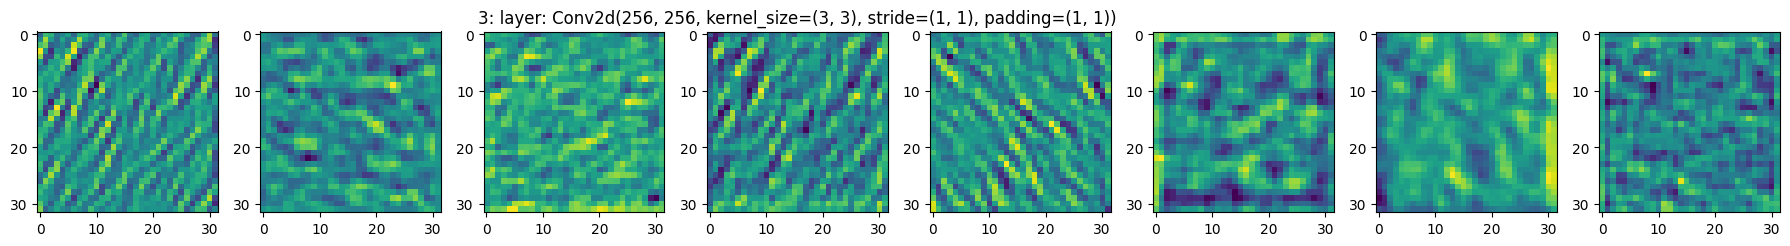

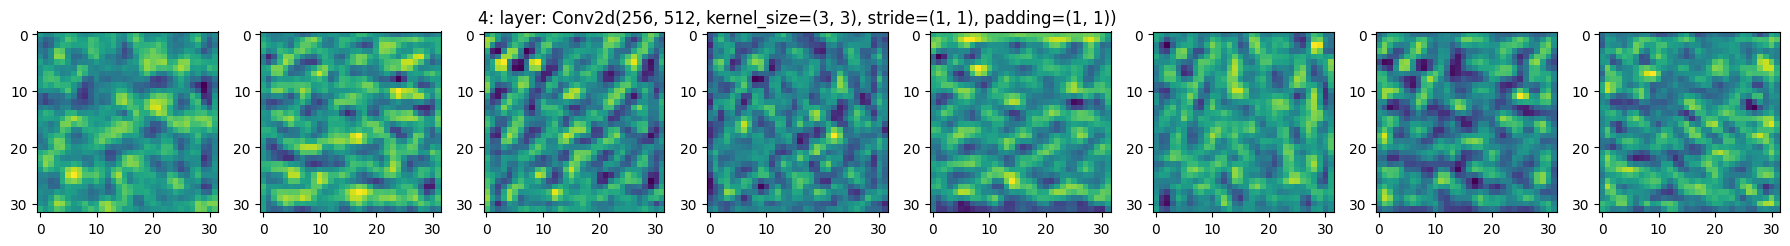

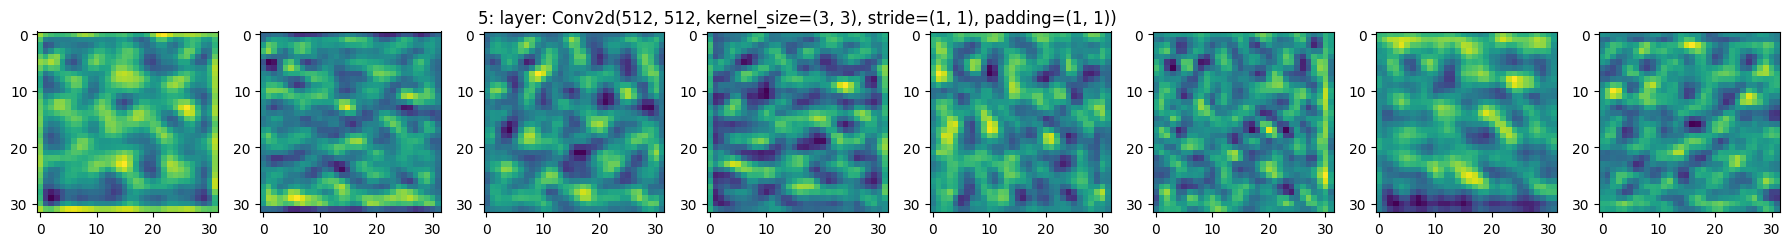

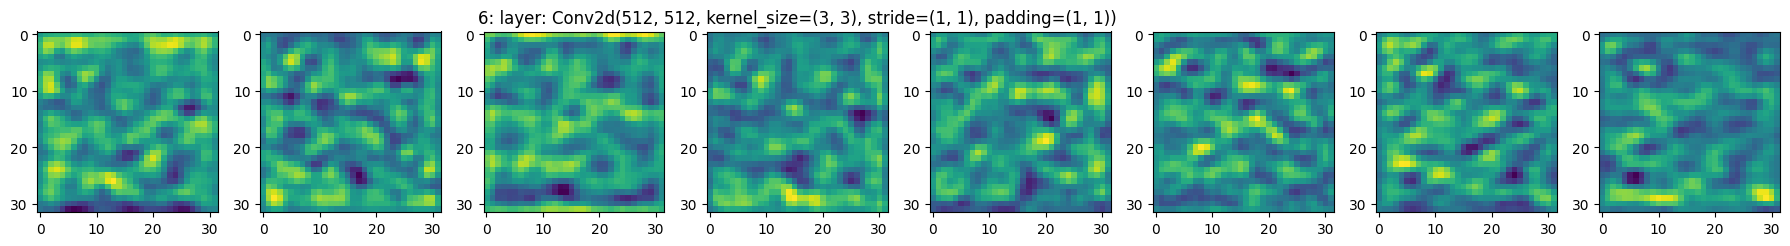

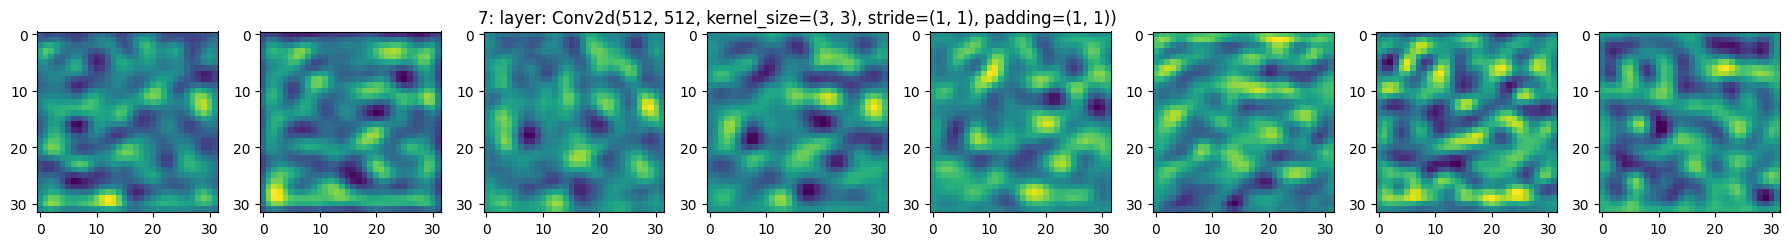

In [29]:
# check if the lists have same size
print(len(conv_layers) == len(batch_norm_layers))

layers_output = []
names = list()
image = torch.Tensor(dataset_numpy[:1]) # ToChange - number of images
#print(image.shape)

for layer, norm_weights in zip(conv_layers, batch_norm_weights):
    # prediction for each layer
    # output taken as input for next one
    image = layer(image)
    np_fmps = image.detach().numpy()
    np_fmps = np.moveaxis(np_fmps, 0, 1)
    entropy = [0.0] * np_fmps.shape[0]
    print(np_fmps.shape)
    
    for channel in range(np_fmps.shape[0]):
        temp_ent = 0.0
        for fmp in np_fmps[channel]:
            # ToDo
            # normalizing the outputs via batchnom scale and shift
            fmp = ((fmp * norm_weights[0][channel]) + norm_weights[1][channel])
            #print(np.max(fmp))
            #print(np.min(fmp))
            
            if np.min(fmp) < 0.0:
                fmp = fmp + np.abs(np.min(fmp))
            fmp_n = (fmp - np.min(fmp)) / np.max(fmp - np.min(fmp)) * 255.0
            #print(np.max(fmp_n))
            #print(np.min(fmp_n))
            
            fmp = np.asarray(fmp_n, dtype=np.ubyte)
            # ToDo
            # Shanon Entropy
            # It's how unexpected each value is given the other values. Thus, it is related to the amount of information present in the image
            # scale the image to uint8
            marg = np.histogramdd(np.ravel(fmp), bins = 256)[0]/fmp.size
            #print(marg)
            marg = list(filter(lambda p: p > 0, np.ravel(marg)))
            temp_ent += -np.sum(np.multiply(marg, np.log2(marg)))
            
        entropy[channel] = temp_ent / np_fmps[channel].shape[0]

    print("Layer: {}".format(str(layer).rstrip()))
    print("Shannon entropy in bits: {}".format(sum(entropy) / (np_fmps.shape[0])))
    layers_output.append(np_fmps)
    names.append(str(layer).rstrip())
    plot_feature_maps_entropy(entropy, str(layer).rstrip())
    
#print(len(outputs))
plot_feature_maps(layers_output, names)